In [1]:
%matplotlib nbagg
import matplotlib.pyplot as plt

# load the qcodes path, until we have this installed as a package
import sys

qcpath = '/Users/alex/qdev/Qcodes'
if qcpath not in sys.path:
    sys.path.append(qcpath)

import qcodes as q

q.set_mp_method('spawn')  # force Windows behavior on mac

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [2]:
# spawn doesn't like function or class definitions in the interpreter
# session - had to move them to a file.
from toymodel import AModel, MockGates, MockSource, MockMeter

# no extra processes running yet
q.active_children()

[]

In [3]:
# now create this "experiment"
model = AModel()
gates = MockGates('gates', model)
source = MockSource('source', model)
meter = MockMeter('meter', model)

station = q.Station(gates, source, meter)

# could measure any number of things by adding arguments to this
# function call, but here we're just measuring one, the meter amplitude
station.set_measurement(meter.amplitude)

# it's nice to have the key parameters be part of the global namespace
# that way they're objects that we can easily set, get, and slice
# this could be simplified to a station method that gathers all parameters
# and adds them all as (disambiguated) globals, printing what it did
# something like:
#   station.gather_parameters(globals())
c0, c1, c2, vsd = gates.chan0, gates.chan1, gates.chan2, source.amplitude

# check that a DataServer is running (not yet implemented, but when we have
# a monitor, defining a station will start the DataServer to run the monitor)
q.active_children()

[]

In [4]:
# we can get the measured quantities right now
station.measure()

[0.117]

In [5]:
# start a Loop (which by default runs in a seprarate process)
# the sweep values are defined by slicing the parameter object
# but more complicated sweeps (eg nonlinear, or adaptive) can
# easily be used instead
data = q.Loop(c0[-20:20:0.1], 0.1).run(location='testsweep')

DataSet: DataMode.PULL_FROM_SERVER, location='testsweep'
   chan0: chan0
   amplitude: amplitude
started at 2015-12-12 22:38:09


In [6]:
# now there should be two processes running, DataServer and a sweep
q.active_children()

[<MeasurementLoop-2, started daemon>, <DataServer-1, started daemon>]

In [7]:
# bring the data into the main process and display it as numbers
data.sync()
data.arrays

{'amplitude': DataArray: amplitude
 array([ 0.117,  0.117,  0.115,  0.111,  0.106,  0.099,  0.092,  0.085,
         0.077,  0.071,  0.064,  0.058,  0.053,  0.048,  0.044,  0.04 ,
         0.037,  0.034,  0.031,  0.029,  0.027,  0.025,  0.023,  0.022,
         0.02 ,  0.019,  0.018,  0.017,  0.016,  0.015,  0.014,  0.013,
         0.013,  0.012,  0.011,  0.011,  0.01 ,  0.01 ,  0.01 ,  0.009,
         0.009,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
           nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
           nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
           nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
           nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
           nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
           nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
           nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
           nan,    nan,    na

<IPython.core.display.Javascript object>


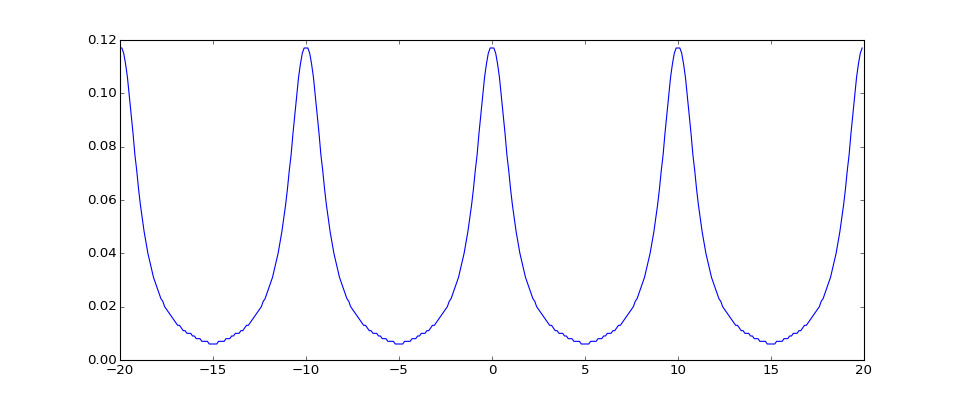

In [19]:
# plot (can also be done repeatedly while the sweep is running)
# next up: create an active plot that will update itself automatically
# (via javascript, so the main python stays accessible) as long as the sweep is running
# as well as provide some nicer styling and labeling defaults
data.sync()
plt.figure(figsize=(12, 5))
# because we pass through the ndarray attributes, matplotlib can plot DataArrays directly
plt.plot(data.chan0, data.amplitude)
plt.show()

In [20]:
data2 = q.Loop(c1[-15:15:1], 0.1).loop(c0[-15:12:.5], 0.01).each(
    meter.amplitude, # first measurement, at c2=0 -> amplitude_0 bcs it's action 0
    q.Task(c2.set, 1), # action 1 -> 
    q.Wait(0.001),
    q.Task(print, '!'), # Loop runs in the background, so ! gets printed in the notebook server terminal
    meter.amplitude, # second measurement, at c2=1 -> amplitude_4 bcs it's action 4
    q.Task(c2.set, 0)
    ).run(location='test2d')

DataSet: DataMode.PULL_FROM_SERVER, location='test2d'
   chan1: chan1
   amplitude_4: amplitude
   chan0: chan0
   amplitude_0: amplitude
started at 2015-12-12 22:39:06


<IPython.core.display.Javascript object>


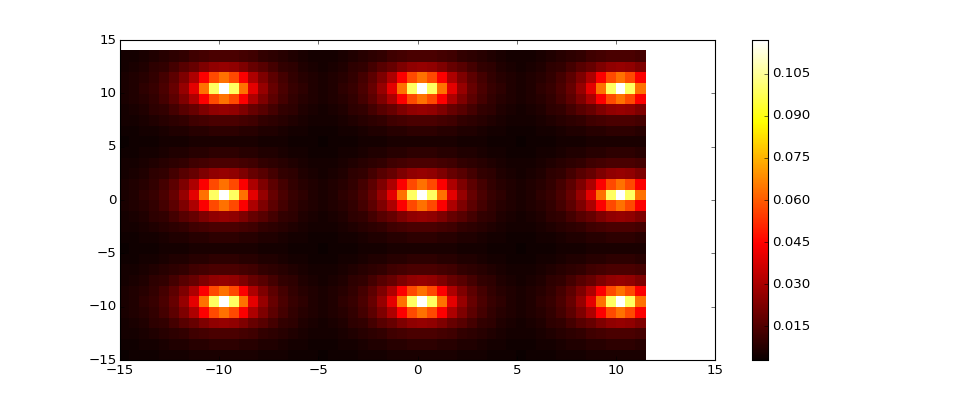

In [25]:
# again, can call this repeatedly while the plot is running
# this plot shows the first array collected, amplitude_0 (at c2=0)
data2.sync()
import numpy.ma as ma
plt.figure(figsize=(12, 5))
# pcolormesh needs NaN masked out or it barfs
plt.pcolormesh(ma.masked_invalid(data2.chan0),
               ma.masked_invalid(data2.chan1),
               ma.masked_invalid(data2.amplitude_0),
               cmap=plt.cm.hot)
plt.colorbar()
plt.show()

<IPython.core.display.Javascript object>


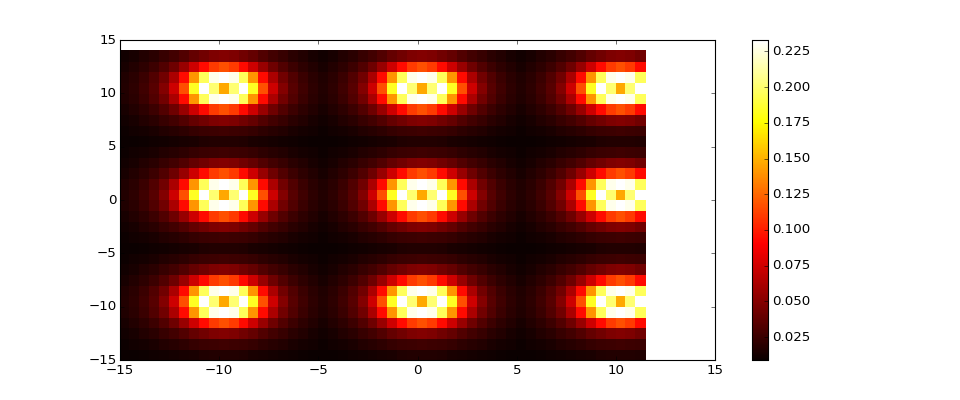

In [26]:
# this plot shows the second array collected, amplitude_0 (at c2=1)
# note that these are acquired within the same 2D sweep
# as you can see if you run this cell and the above while the Loop is running
plt.figure(figsize=(12, 5))
# pcolormesh needs NaN masked out or it barfs
plt.pcolormesh(ma.masked_invalid(data2.chan0),
               ma.masked_invalid(data2.chan1),
               ma.masked_invalid(data2.amplitude_4),
               cmap=plt.cm.hot)
plt.colorbar()
plt.show()

In [37]:
# I obviously have a lot to figure out about matplotlib...
# calling the above redraws constantly to "live update"
# generates warnings after a while about too many open figures
plt.close('all')

In [5]:
data3 = q.Loop(c1[-15:15:1], 0.1).each(
    q.Task(c0.set, -10),
    q.Task(c2.set, 0),
    # a 1D measurement
    meter.amplitude,
    # a 2D sweep, .each is actually unnecessary bcs this is the default measurement
    q.Loop(c0[-15:15:1], 0.01).each(meter.amplitude),
    q.Task(c0.set, -10),
    # a 2D sweep with the same outer but different inner loop
    q.Loop(c2[-10:10:0.2], 0.01)
).run(location='test_multi_d')

DataSet: DataMode.PULL_FROM_SERVER, location='test_multi_d'
   amplitude_5_0: amplitude
   chan2: chan2
   amplitude_2: amplitude
   chan0: chan0
   chan1: chan1
   amplitude_3_0: amplitude
started at 2015-12-12 22:51:20


<IPython.core.display.Javascript object>


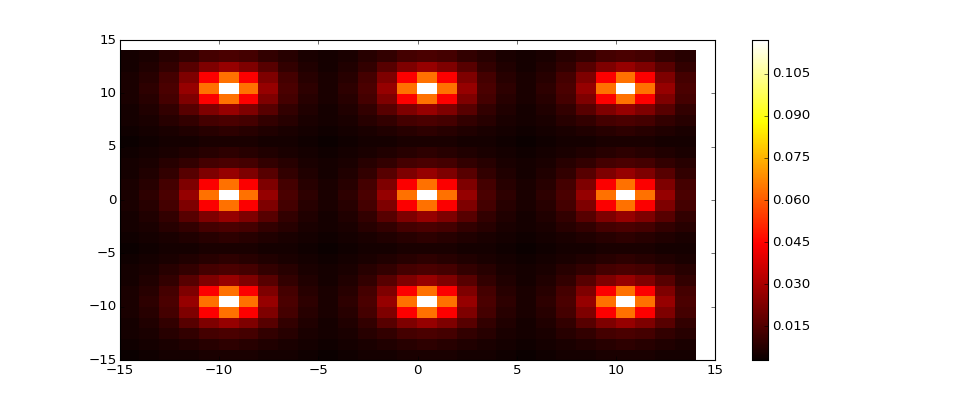

In [21]:
data3.sync()
plt.figure(figsize=(12, 5))
# pcolormesh needs NaN masked out or it barfs
plt.pcolormesh(ma.masked_invalid(data3.chan0),
               ma.masked_invalid(data3.chan1),
               ma.masked_invalid(data3.amplitude_3_0),
               cmap=plt.cm.hot)
plt.colorbar()
plt.show()

<IPython.core.display.Javascript object>


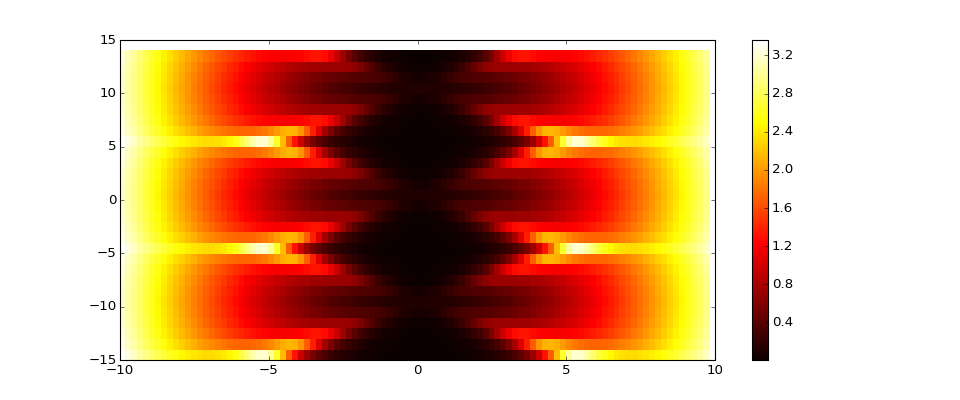

In [20]:
plt.figure(figsize=(12, 5))
# pcolormesh needs NaN masked out or it barfs
plt.pcolormesh(ma.masked_invalid(data3.chan2),
               ma.masked_invalid(data3.chan1),
               ma.masked_invalid(data3.amplitude_5_0),
               cmap=plt.cm.hot)
plt.colorbar()
plt.show()